In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import feather as ft
import pytensor
from pytensor import tensor as T
from sklearn.preprocessing import scale, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
import itertools
import pickle
import dill

In [20]:
def preprocess_survdata(survdata):
    survdata = survdata[["time", "status", "chemo", "rt", "brachy", "eclass2_ngs", "stage_main", "age_dx", "hist_rev"]]
    survdata['eclass2_ngs'].replace(['NSMP/p53wt', 'p53abn', 'MMRd', 'POLEmut'],
                        [0, 1, 2, 3], inplace=True)
    survdata['stage_main'].replace(['I', 'II', 'III', 'IV'],
                        [0, 1, 2, 3], inplace=True)
    survdata['hist_rev'].replace(['carcinosarcoma (MMMT)', 'endometrioid', 'serous', 'mixed endometrioid and serous',
                                  'mixed serous and moderately differentiated', 'clear cell', 'other', 'endometrioid (squamous)',
                                  'mixed', 'mesonephric-like', 'undifferentiated', 'dedifferentiated'],
                                 [1, 0, 0, 0,
                                  0, 0, 0, 0,
                                  0, 0, 0, 0], inplace=True)
    survdata['age_dx'] = scale(survdata['age_dx'], axis=0, with_mean=True, with_std=True, copy=True)
    return survdata

def preprocess_count_area_arrays(til_counts, sample_names, variable_types=[]):
    count_df = til_counts[['acc_num', 'variable', 'count', 'region']]

    if len(variable_types) > 0:
        print("Filtering by variable type ...")
        count_df = count_df[count_df['variable'].isin(variable_types)]
    
    unique_ids = count_df['acc_num'].unique()
    unique_cell_types = count_df['variable'].unique()
    unique_regions = count_df['region'].unique()
    
    # Create an empty 3D NumPy array filled with zeros
    count_array = np.zeros((len(sample_names), len(unique_cell_types), len(unique_regions)))
    
    # Get indices for advanced indexing
    id_indices = np.searchsorted(sample_names, count_df['acc_num'])
    cell_type_indices = np.searchsorted(unique_cell_types, count_df['variable'])
    region_indices = np.searchsorted(unique_regions, count_df['region'])
    
    # Assign 'count' values using advanced indexing
    count_array[id_indices, cell_type_indices, region_indices] = count_df['count']

    area_df = til_counts[['acc_num', 'area', 'region']].drop_duplicates()

    # Create an empty 3D NumPy array filled with zeros
    area_array = np.zeros((len(sample_names), len(unique_regions)))
    
    # Get indices for advanced indexing
    id_indices = np.searchsorted(sample_names, area_df['acc_num'])
    region_indices = np.searchsorted(unique_regions, area_df['region'])
    
    # Assign 'count' values using advanced indexing
    area_array[id_indices, region_indices] = area_df['area']
    
    return count_array, area_array

def coxph_mixture_model(count_data, area, exposure, death, stage, rt, brachy, intervals, subtype, histotype,
                        n_histotypes, n_subtypes, n_samples, n_clusters, n_stages, n_cell_types, additional_dimension):
    
    epsilon = 1e-6  # Small positive constant to prevent division by zero
    mean_mu = np.mean(count_data/area[:,np.newaxis,:], axis = 0)
    mean_mu = np.repeat(mean_mu[np.newaxis, :, :], n_clusters, axis=0).transpose(0, 2, 1)
    area_nonzero = area + epsilon

    ## Centers for RBF-based dispersion
    n_centers = 20
    interval_length = np.max(count_data)/(n_centers-1.)
    centers = np.arange(n_centers) * interval_length
    print(centers)
    
    coords = {"intervals": intervals}
    
    with pm.Model(coords = coords) as survival_mixture_model:
        # Priors for survival coefficients
        
        #beta_subtype0 = pm.Normal("beta_subtype0", mu=0, sigma=5, shape=n_subtypes-1)
        #beta_subtype = pm.Deterministic("beta_subtype", pm.math.concatenate([[0], beta_subtype0]))
        beta_histotype0 = pm.Normal("beta_histotype0", mu=0, sigma=5, shape=n_histotypes-1)
        beta_histotype = pm.Deterministic("beta_histotype", pm.math.concatenate([[0], beta_histotype0]))
        beta_clust0 = pm.Normal("beta_clust0", mu=0, sigma=5, shape=n_clusters-1)
        beta_clust = pm.Deterministic("beta_clust", pm.math.concatenate([[0], beta_clust0]))
        beta_stage0 = pm.Normal("beta_stage0", mu=0, sigma=5, shape=n_stages-1)
        beta_stage = pm.Deterministic("beta_stage", pm.math.concatenate([[0], beta_stage0]))
        beta_age = pm.Normal("beta_age", mu=0, sigma=5)
        beta_chemo = pm.Normal("beta_chemo", mu = 0, sigma = 5)
        beta_rt = pm.Normal("beta_rt", mu = 0, sigma = 5)
        beta_brachy = pm.Normal("beta_brachy", mu = 0, sigma = 5)
    
        # Priors for count coefficient
        #mu_clust = pm.Normal("mu_clust", mu=0, sigma=5, shape=(n_clusters, additional_dimension, n_cell_types))
        mu_clust = pm.Gamma("mu_clust", mu = mean_mu, sigma = 100, shape = (n_clusters, additional_dimension, n_cell_types))
        #mu_clust = pm.math.concatenate([np.zeros((1, additional_dimension, n_cell_types)), mu_clust0])
        
        # Latent categorical variable for 'clust'
        props = pm.Dirichlet('props', np.ones(n_clusters))
        clust = pm.Categorical("clust", p=props, shape=n_samples)
    
        # Poisson distribution for count data using adjusted area and mu_clust
        count_mu = area_nonzero[:, :, np.newaxis] * mu_clust[clust] #T.exp(mu_clust[clust])  # Use 'area' as multiplier

        # RBF based NB dispersion 
        theta_a = pm.Normal("theta_a", mu = 0, sigma=1, shape=n_centers)
        theta_b = pm.Normal("theta_b", mu = 0, sigma=1, shape=n_centers)
        print(count_mu.shape.eval())
        print(centers[np.newaxis, np.newaxis, np.newaxis, :])
        print((T.reshape(T.repeat(count_mu, repeats=n_centers), newshape=(n_samples, additional_dimension, n_cell_types, n_centers)) - centers[np.newaxis, np.newaxis, np.newaxis, :]).shape.eval())
        count_disp = T.dot(T.exp(-T.exp(theta_b) * (T.reshape(T.repeat(count_mu, repeats=n_centers), newshape=(n_samples, additional_dimension, n_cell_types, n_centers)) - centers[np.newaxis, np.newaxis, np.newaxis, :])**2), T.exp(theta_a)) + epsilon
        #count_disp = T.sum(T.exp(-1. * T.exp(theta_b) * (T.reshape(T.repeat(count_mu, repeats=n_centers), newshape=(n_samples, additional_dimension, n_cell_types, n_centers)) - centers[np.newaxis, np.newaxis, np.newaxis, :])**2), axis=3)
        print(count_disp.shape.eval())
        print(count_disp[0].eval())
    
        # Likelihood for count data
        #count_v = pm.Poisson("count_v", mu=count_mu, observed=count_data.transpose(0, 2, 1))
        count_v = pm.NegativeBinomial("count_v", mu=count_mu, alpha=count_disp, observed=count_data.transpose(0, 2, 1))
        
        # Don't forget lambda_0 AFTERWARDS ADD THIS -- need to fix intercepts and dimensions as a result
        lambda0 = pm.Gamma("lambda0", 0.1, 0.1, dims = "intervals") # 0.01, 0.05, 0.1
        
        # Linear predictor for Cox PH model
        linear_predictor = (
            #beta_subtype[subtype]
            beta_histotype[histotype]
            + beta_clust[clust]
            + beta_stage[stage]
            + beta_age * age
            + beta_chemo * chemo
            + beta_rt * rt
            + beta_brachy * brachy
        )
    
        lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(linear_predictor), lambda0))
        mu = pm.Deterministic("mu", exposure * lambda_)
    
        # Poisson-Cox PH equivalence
        obs = pm.Poisson("obs", mu=mu, observed=death)
    
        survival_mixture_model.debug(verbose = True)
    
        trace = pm.sample(2000, tune=1000, chains=1)

        return trace, survival_mixture_model

def create_trace_table(trace, export_variables = ['props', 'beta_clust', 'beta_stage', 'beta_age', 'beta_chemo', 'beta_rt', 'beta_brachy', 'beta_histotype']):
    # Create an empty list to store DataFrames
    export_dfs = []
    
    # Iterate over the list of column names
    for variable in export_variables:
        print(variable)
        posterior = trace.posterior[variable][0]
        
        if posterior.ndim == 2:
            posterior_clust_assignments = pd.DataFrame(posterior, columns=[f'{variable}_{i}' for i in range(posterior.shape[1])])
        elif posterior.ndim == 1:
            posterior_clust_assignments = pd.DataFrame(posterior, columns=[variable])
        else:
            print("Should not get here.")
        
        # Append the DataFrame to the list
        export_dfs.append(posterior_clust_assignments)
    
    # Concatenate the DataFrames horizontally (column bind)
    trace_table = pd.concat(export_dfs, axis=1)
    return trace_table

## Overall survival

In [3]:
survdata_full_os = ft.read_dataframe('../data/survival_model_inputs/p53abn/fit_data_os.feather')
til_counts_wide_os = ft.read_dataframe('../data/survival_model_inputs/p53abn/til_counts_wide_os.feather')

survdata_os = preprocess_survdata(survdata_full_os)
survdata_os_samples = survdata_full_os['acc_num'].values

#variable_filters = ['count_tcyto', 'count_thelper', 'count_treg']
variable_filters = []

#count_array, area_array = preprocess_count_area_arrays(til_counts_wide_os, survdata_os_samples)
count_array, area_array = preprocess_count_area_arrays(til_counts_wide_os, survdata_os_samples, 
                                                       variable_types=variable_filters)

/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/3770165307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survdata['eclass2_ngs'].replace(['NSMP/p53wt', 'p53abn', 'MMRd', 'POLEmut'],
/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/3770165307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survdata['stage_main'].replace(['I', 'II', 'III', 'IV'],
/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/3770165307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [4]:
n_samples = count_array.shape[0]
time = survdata_os['time'].values
event = survdata_os['status'].values

# Simulated covariates
n_clusters = 2 # number of latent clusters to infer
n_subtypes = len(survdata_os['eclass2_ngs'].unique())
n_stages = len(survdata_os['stage_main'].unique())
n_cell_types = count_array.shape[1]
n_histotypes = len(survdata_os['hist_rev'].unique())
additional_dimension = 2 # tumor and stroma


area = area_array
subtype = survdata_os['eclass2_ngs'].values
stage = survdata_os['stage_main'].values
histotype = survdata_os['hist_rev'].values
age = survdata_os['age_dx'].values
chemo = survdata_os['chemo'].values.astype(int)
rt = survdata_os['rt'].values.astype(int)
brachy = survdata_os['brachy'].values.astype(int)
count_data = count_array

count_data.shape

(250, 6, 2)

In [5]:
samples = np.arange(n_samples)

interval_length = 0.3
interval_bounds = np.arange(0, time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

last_period = np.floor((time - 0.01) / interval_length).astype(int)

death = np.zeros((n_samples, n_intervals))
death[samples, last_period] = event

exposure = np.greater_equal.outer(time, interval_bounds[:-1]) * interval_length
exposure[samples, last_period] = time - interval_bounds[last_period]

In [9]:
os_trace, os_model = coxph_mixture_model(count_data, area, exposure, death, stage, rt, brachy, intervals, subtype, histotype,
                                         n_histotypes, n_subtypes, n_samples, n_clusters, n_stages, n_cell_types, additional_dimension)

[   0.           58.68421053  117.36842105  176.05263158  234.73684211
  293.42105263  352.10526316  410.78947368  469.47368421  528.15789474
  586.84210526  645.52631579  704.21052632  762.89473684  821.57894737
  880.26315789  938.94736842  997.63157895 1056.31578947 1115.        ]
[250   2   6]
[[[[   0.           58.68421053  117.36842105  176.05263158
     234.73684211  293.42105263  352.10526316  410.78947368
     469.47368421  528.15789474  586.84210526  645.52631579
     704.21052632  762.89473684  821.57894737  880.26315789
     938.94736842  997.63157895 1056.31578947 1115.        ]]]]
[250   2   6  20]
[250   2   6]
[[1.00000000e-06 2.09928186e-06 1.00000000e-06 1.85847306e-02
  1.00000000e-06 1.00000000e-06]
 [6.02979854e-01 6.02979854e-01 6.02979854e-01 1.00031775e-06
  5.90881922e-01 6.02979854e-01]]
point={'beta_histotype0': array([0.]), 'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), '

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_histotype0, beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 2914 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [10]:
pm.summary(os_trace, var_names=["props", "beta_clust", "beta_stage", "beta_histotype", 
                                "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.449,0.033,0.392,0.513,0.001,0.001,1585.0,1231.0,NaN
props[1],0.551,0.033,0.487,0.608,0.001,0.001,1585.0,1231.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.520,0.220,-0.934,-0.122,0.007,0.005,892.0,1111.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],1.139,0.682,-0.064,2.454,0.019,0.014,1269.0,1165.0,NaN
beta_stage[2],1.238,0.295,0.662,1.761,0.011,0.008,715.0,1009.0,NaN
beta_stage[3],2.338,0.323,1.752,2.963,0.015,0.011,470.0,800.0,NaN
beta_histotype[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_histotype[1],0.352,0.383,-0.391,1.033,0.010,0.009,1397.0,923.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


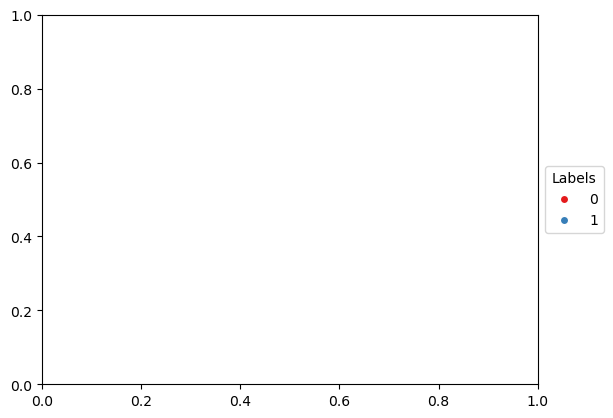

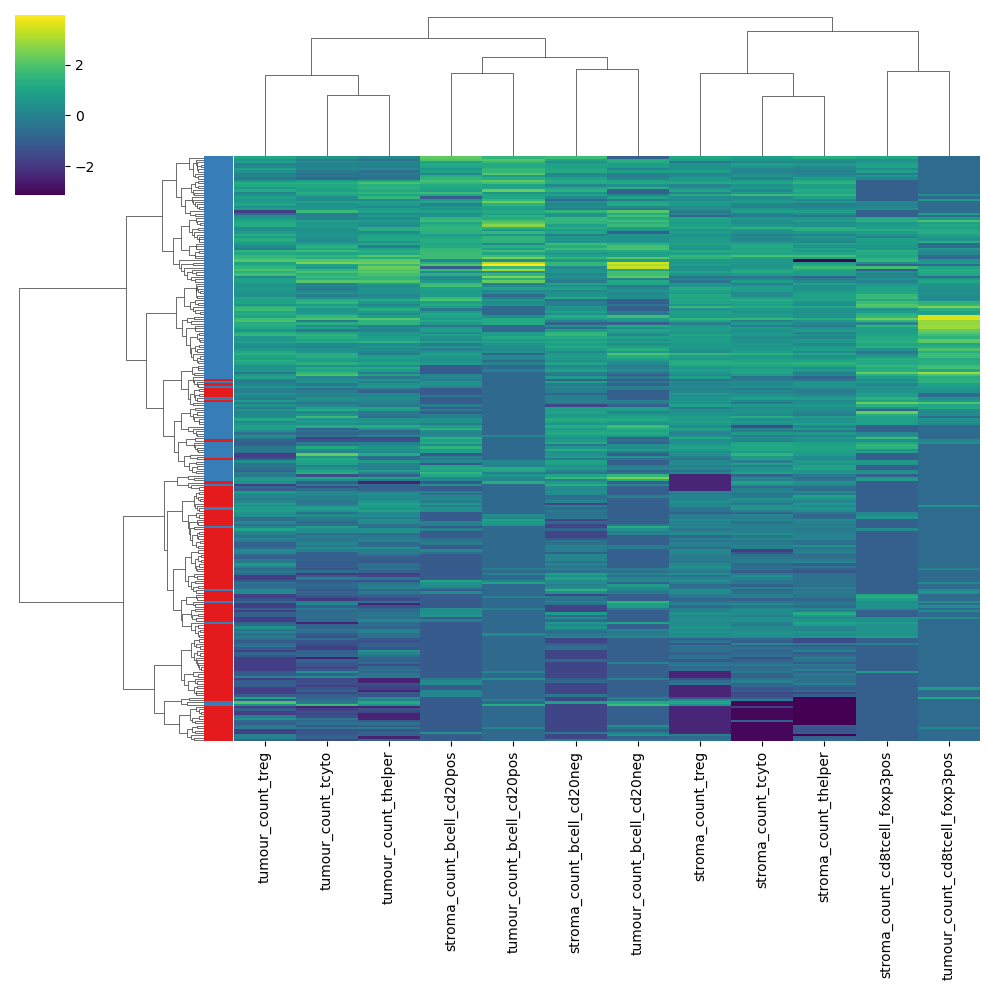

In [11]:
os_clust_assignments = np.round(pm.summary(os_trace, var_names=["clust"])['mean'].values).astype(int)

if len(variable_filters) == 0:
    unique_variables = til_counts_wide_os['variable'].unique()
else:
    unique_variables = til_counts_wide_os[til_counts_wide_os['variable'].isin(variable_filters)]['variable'].unique()

heatmap_colnames = [f"{b}_{a}" for a, b in itertools.product(unique_variables, til_counts_wide_os['region'].unique())]

raw_densities = np.log(count_data/area[:,np.newaxis,:] + 1.)
raw_densities = raw_densities.reshape([n_samples, n_cell_types * additional_dimension])

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the data and transform the data
raw_densities = scaler.fit_transform(raw_densities)

# Convert labels to categorical colors
label_colors = sns.color_palette("Set1", n_colors=len(np.unique(os_clust_assignments)))
row_colors = [label_colors[label] for label in np.array(os_clust_assignments)]


legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(np.unique(os_clust_assignments), label_colors)]
plt.legend(handles=legend_elements, title='Labels', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a clustered heatmap using Seaborn
sns.clustermap(raw_densities, cmap='viridis', row_colors=row_colors, xticklabels=heatmap_colnames, yticklabels=False, method = 'ward')
plt.show()

In [21]:
os_trace_table = create_trace_table(os_trace)

os_clust_assignments

props
beta_clust
beta_stage
beta_age
beta_chemo
beta_rt
beta_brachy
beta_histotype


array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0])

## Progression-free survival

In [13]:
survdata_full_pfs = ft.read_dataframe('../data/survival_model_inputs/p53abn/fit_data_pfs.feather')
til_counts_wide_pfs = ft.read_dataframe('../data/survival_model_inputs/p53abn/til_counts_wide_pfs.feather')

survdata_pfs = preprocess_survdata(survdata_full_pfs)
survdata_pfs_samples = survdata_full_pfs['acc_num'].values

count_array, area_array = preprocess_count_area_arrays(til_counts_wide_pfs, survdata_pfs_samples)

/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/3770165307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survdata['eclass2_ngs'].replace(['NSMP/p53wt', 'p53abn', 'MMRd', 'POLEmut'],
/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/3770165307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survdata['stage_main'].replace(['I', 'II', 'III', 'IV'],
/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/3770165307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [14]:
n_samples = count_array.shape[0]
time = survdata_pfs['time'].values
event = survdata_pfs['status'].values

# Simulated covariates
n_clusters = 2 # number of latent clusters to infer
n_subtypes = len(survdata_pfs['eclass2_ngs'].unique())
n_stages = len(survdata_pfs['stage_main'].unique())
n_cell_types = count_array.shape[1]
n_histotypes = len(survdata_pfs['hist_rev'].unique())
additional_dimension = 2 # tumor and stroma


area = area_array
subtype = survdata_pfs['eclass2_ngs'].values
stage = survdata_pfs['stage_main'].values
age = survdata_pfs['age_dx'].values
histotype = survdata_pfs['hist_rev'].values
chemo = survdata_pfs['chemo'].values.astype(int)
rt = survdata_pfs['rt'].values.astype(int)
brachy = survdata_pfs['brachy'].values.astype(int)
count_data = count_array

count_data.shape

(241, 6, 2)

In [15]:
samples = np.arange(n_samples)

interval_length = 0.3
interval_bounds = np.arange(0, time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

last_period = np.floor((time - 0.01) / interval_length).astype(int)

death = np.zeros((n_samples, n_intervals))
death[samples, last_period] = event

exposure = np.greater_equal.outer(time, interval_bounds[:-1]) * interval_length
exposure[samples, last_period] = time - interval_bounds[last_period]

In [18]:
pfs_trace, pfs_model = coxph_mixture_model(count_data, area, exposure, death, stage, rt, brachy, intervals, subtype, histotype,
                                         n_histotypes, n_subtypes, n_samples, n_clusters, n_stages, n_cell_types, additional_dimension)

[   0.           58.68421053  117.36842105  176.05263158  234.73684211
  293.42105263  352.10526316  410.78947368  469.47368421  528.15789474
  586.84210526  645.52631579  704.21052632  762.89473684  821.57894737
  880.26315789  938.94736842  997.63157895 1056.31578947 1115.        ]
[241   2   6]
[[[[   0.           58.68421053  117.36842105  176.05263158
     234.73684211  293.42105263  352.10526316  410.78947368
     469.47368421  528.15789474  586.84210526  645.52631579
     704.21052632  762.89473684  821.57894737  880.26315789
     938.94736842  997.63157895 1056.31578947 1115.        ]]]]
[241   2   6  20]
[241   2   6]
[[8.61358235e-01 1.02657784e+00 5.00031815e-01 1.00000000e-06
  1.00000000e-06 1.00000000e-06]
 [1.10783379e+00 1.10783379e+00 1.10783342e+00 1.00000000e-06
  1.00000000e-06 1.10783363e+00]]
point={'beta_histotype0': array([0.]), 'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), '

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_histotype0, beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3888 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
pm.summary(pfs_trace, var_names=["props", "beta_clust", "beta_stage",
                                "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.435,0.032,0.378,0.496,0.001,0.001,1511.0,806.0,NaN
props[1],0.565,0.032,0.504,0.622,0.001,0.001,1511.0,806.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.345,0.220,-0.746,0.075,0.007,0.005,959.0,1270.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],-0.026,0.837,-1.518,1.496,0.022,0.020,1570.0,1111.0,NaN
beta_stage[2],1.376,0.270,0.861,1.868,0.009,0.006,963.0,1302.0,NaN
beta_stage[3],2.149,0.324,1.535,2.730,0.009,0.007,1192.0,1370.0,NaN
beta_age,0.011,0.108,-0.210,0.198,0.004,0.003,929.0,721.0,NaN
beta_chemo,-0.115,0.272,-0.590,0.392,0.009,0.007,834.0,1129.0,NaN


In [22]:
pfs_trace_table = create_trace_table(pfs_trace)

pfs_clust_assignments = np.round(pm.summary(pfs_trace, var_names=["clust"])['mean'].values).astype(int)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


props
beta_clust
beta_stage
beta_age
beta_chemo
beta_rt
beta_brachy
beta_histotype


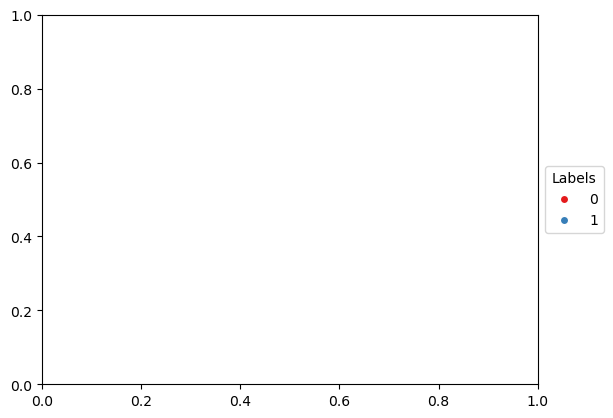

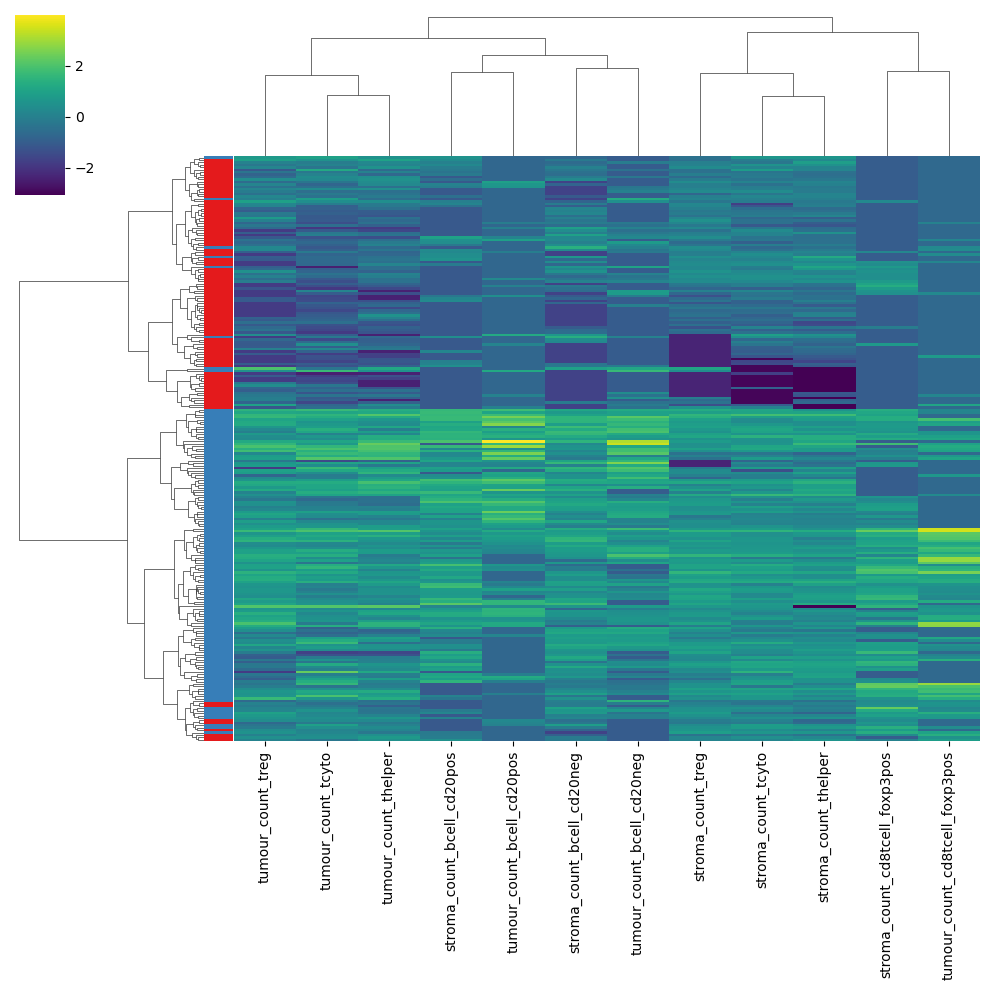

In [23]:
heatmap_colnames = [f"{b}_{a}" for a, b in itertools.product(til_counts_wide_pfs['variable'].unique(), til_counts_wide_pfs['region'].unique())]

raw_densities = np.log(count_data/area[:,np.newaxis,:] + 1.)
raw_densities = raw_densities.reshape([n_samples, n_cell_types * additional_dimension])

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the data and transform the data
raw_densities = scaler.fit_transform(raw_densities)

# Convert labels to categorical colors
label_colors = sns.color_palette("Set1", n_colors=len(np.unique(pfs_clust_assignments)))
row_colors = [label_colors[label] for label in np.array(pfs_clust_assignments)]


legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(np.unique(pfs_clust_assignments), label_colors)]
plt.legend(handles=legend_elements, title='Labels', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a clustered heatmap using Seaborn
sns.clustermap(raw_densities, cmap='viridis', row_colors=row_colors, xticklabels=heatmap_colnames, yticklabels=False, method = 'ward')
plt.show()

## Disease-specific survival

In [24]:
survdata_full_dss = ft.read_dataframe('../data/survival_model_inputs/p53abn/fit_data_dss.feather')
til_counts_wide_dss = ft.read_dataframe('../data/survival_model_inputs/p53abn/til_counts_wide_dss.feather')

survdata_dss = preprocess_survdata(survdata_full_dss)
survdata_dss_samples = survdata_full_dss['acc_num'].values

count_array, area_array = preprocess_count_area_arrays(til_counts_wide_dss, survdata_dss_samples)

/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/414501156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survdata['eclass2_ngs'].replace(['NSMP/p53wt', 'p53abn', 'MMRd', 'POLEmut'],
/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/414501156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survdata['stage_main'].replace(['I', 'II', 'III', 'IV'],
/var/folders/m3/0v6jb00x41n97x4pn8lblmvr0000gn/T/ipykernel_52729/414501156.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

In [25]:
n_samples = count_array.shape[0]
time = survdata_dss['time'].values
event = survdata_dss['status'].values

# Simulated covariates
n_clusters = 2 # number of latent clusters to infer
n_subtypes = len(survdata_dss['eclass2_ngs'].unique())
n_stages = len(survdata_dss['stage_main'].unique())
n_cell_types = count_array.shape[1]
n_histotypes = len(survdata_dss['hist_rev'].unique())
additional_dimension = 2 # tumor and stroma


area = area_array
subtype = survdata_dss['eclass2_ngs'].values
stage = survdata_dss['stage_main'].values
age = survdata_dss['age_dx'].values
chemo = survdata_dss['chemo'].values.astype(int)
histotype = survdata_dss['hist_rev'].values
rt = survdata_dss['rt'].values.astype(int)
brachy = survdata_dss['brachy'].values.astype(int)
count_data = count_array

count_data.shape

(239, 6, 2)

In [26]:
samples = np.arange(n_samples)

interval_length = 0.3
interval_bounds = np.arange(0, time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

last_period = np.floor((time - 0.01) / interval_length).astype(int)

death = np.zeros((n_samples, n_intervals))
death[samples, last_period] = event

exposure = np.greater_equal.outer(time, interval_bounds[:-1]) * interval_length
exposure[samples, last_period] = time - interval_bounds[last_period]

In [27]:
dss_trace, dss_model = coxph_mixture_model(count_data, area, exposure, death, stage, rt, brachy, intervals, subtype, histotype,
                                         n_histotypes, n_subtypes, n_samples, n_clusters, n_stages, n_cell_types, additional_dimension)

[   0.           58.68421053  117.36842105  176.05263158  234.73684211
  293.42105263  352.10526316  410.78947368  469.47368421  528.15789474
  586.84210526  645.52631579  704.21052632  762.89473684  821.57894737
  880.26315789  938.94736842  997.63157895 1056.31578947 1115.        ]
[239   2   6]
[[[[   0.           58.68421053  117.36842105  176.05263158
     234.73684211  293.42105263  352.10526316  410.78947368
     469.47368421  528.15789474  586.84210526  645.52631579
     704.21052632  762.89473684  821.57894737  880.26315789
     938.94736842  997.63157895 1056.31578947 1115.        ]]]]
[239   2   6  20]
[239   2   6]
[[1.00000000e-06 6.79438255e-01 6.96626766e-01 1.00000000e-06
  1.00000000e-06 1.00000000e-06]
 [6.96626766e-01 6.96626766e-01 6.96626766e-01 1.00000001e-06
  6.96337254e-01 1.00000000e-06]]
point={'beta_histotype0': array([0.]), 'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), '

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_histotype0, beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 2850 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [310]:
pm.summary(dss_trace, var_names=["props", "beta_clust", "beta_stage",
                                "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.447,0.034,0.385,0.511,0.001,0.001,1378.0,1067.0,NaN
props[1],0.553,0.034,0.489,0.615,0.001,0.001,1378.0,1067.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.757,0.275,-1.286,-0.244,0.010,0.007,772.0,856.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],0.240,1.279,-2.327,2.364,0.047,0.040,946.0,607.0,NaN
beta_stage[2],1.516,0.361,0.871,2.206,0.013,0.009,757.0,955.0,NaN
beta_stage[3],2.654,0.379,1.958,3.330,0.015,0.011,621.0,924.0,NaN
beta_age,0.021,0.131,-0.224,0.269,0.005,0.003,813.0,1108.0,NaN
beta_chemo,-0.464,0.322,-1.078,0.129,0.012,0.008,717.0,790.0,NaN


In [311]:
dss_trace_table = create_trace_table(dss_trace)

dss_clust_assignments = np.round(pm.summary(dss_trace, var_names=["clust"])['mean'].values).astype(int)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


props
beta_clust
beta_stage
beta_age
beta_chemo
beta_rt
beta_brachy


## Output model results to pickle

In [313]:

model_outputs = {
    'os_trace_table': os_trace_table,
    'os_clust': os_clust_assignments,
    'pfs_trace_table': pfs_trace_table,
    'pfs_clust': pfs_clust_assignments,
    'dss_trace_table': dss_trace_table,
    'dss_clust': dss_clust_assignments
}
  
with open('../data/survival_model_outputs/p53abn_histotype/model_results.pkl', 'wb') as file:
    pickle.dump(model_outputs, file)

## Scratch

In [190]:
n_centers = 30.
interval_length = np.max(count_data)/n_centers

centers = np.arange(n_centers+1) * interval_length

print(np.array([[1, 2], [3, 4]])[1, 0])
x = np.array([0, 1, 2])
(x * np.reshape(np.repeat([[1, 2], [3, 4]], repeats=3), (2, 2, 3)))[:,:,0]



3


array([[0, 0],
       [0, 0]])

In [8]:
file = open('survival_mixture_modelling.pkl', 'rb')
data = pickle.load(file)

ModuleNotFoundError: No module named '__builtin__'